In [4]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy
import matplotlib.pyplot as plt
import rpy2
from matplotlib import rcParams # for figure size adjustment

# Load data

In [5]:
data_path = "../OneDrive/Documents/scData/hiv/processed_data/"

def load_data (file_name):
    tdata = sc.read_10x_h5(data_path + file_name)
    
    # Some variables can be the same name, which could make errors in the downstream analysis.
    # Add numbers (1, 2, 3, ...) to the variables to make the variables unique.
    tdata.var_names_make_unique()
    
    print(f"The shape of the dataset: n_obs {tdata.shape[0]} x n_vars {tdata.shape[1]}.")
    print("Init barcode count:", tdata.shape[0])
    print("Init_gene_count:", tdata.shape[1], "\n")
    return tdata
    
# normal_1 = load_data("normal_1_filtered_feature_bc_matrix.h5")
normal_2 = load_data("normal_2_filtered_feature_bc_matrix.h5")
normal_3 = load_data("normal_3_filtered_feature_bc_matrix.h5")


c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


The shape of the dataset: n_obs 6453 x n_vars 38606.
Init barcode count: 6453
Init_gene_count: 38606 

The shape of the dataset: n_obs 10765 x n_vars 38606.
Init barcode count: 10765
Init_gene_count: 38606 



c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
# normal_1
normal_2
normal_3

AnnData object with n_obs × n_vars = 10765 × 38606
    var: 'gene_ids', 'feature_types', 'genome'

# Quality control

## Basic cell filtering

In [7]:
for adata in [normal_2, normal_3]:
    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_cells = 3)

## Draw QC plots

In [8]:
# annotate genes to adata
for adata in [normal_2, normal_3]:
    # mitochondrial genes
    adata.var["MT"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith("RPS") | adata.var_names.str.startswith("RPL")
    # hemoglobin genes.
    # adata.var["hb"] = adata.var_names.str.contains("^HB[^(p)]")
    # Malat1
    adata.var["MALAT1"] = adata.var_names.str.contains("MALAT1")
    
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars = ["MT", "ribo", "MALAT1"],
        inplace = True,
        percent_top = [20],
        log1p = True
    )


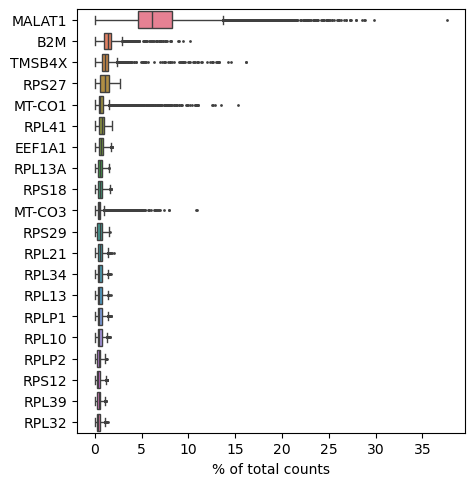

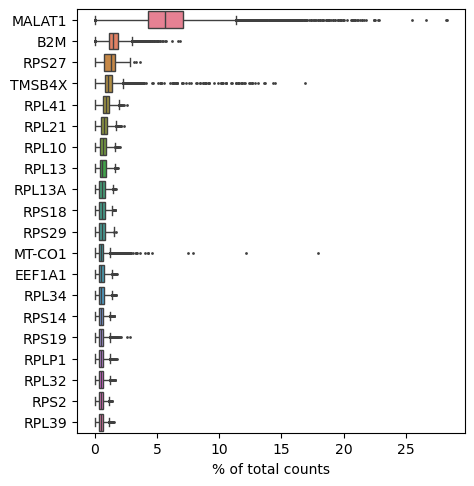

In [9]:
# Highest expressed gene plots

for adata in [normal_2, normal_3]:
    sc.pl.highest_expr_genes(adata, n_top = 20)
    # MALAT1 frequently detected in RNA-seq data captured by poly-A
    # A technical bias need to remove
    # RPS, RPL: ribosomal genes
    # MT-: mitochondrial genes

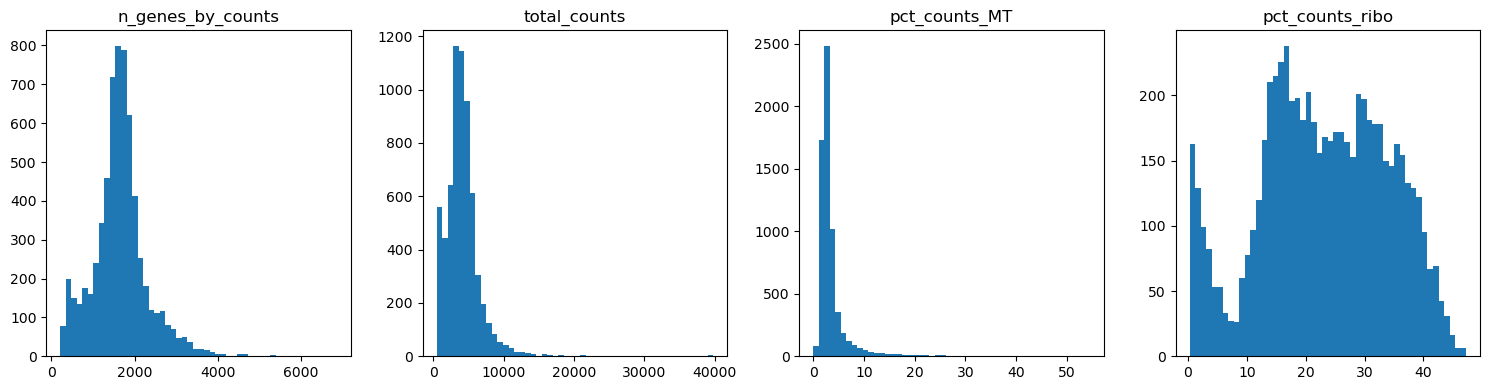

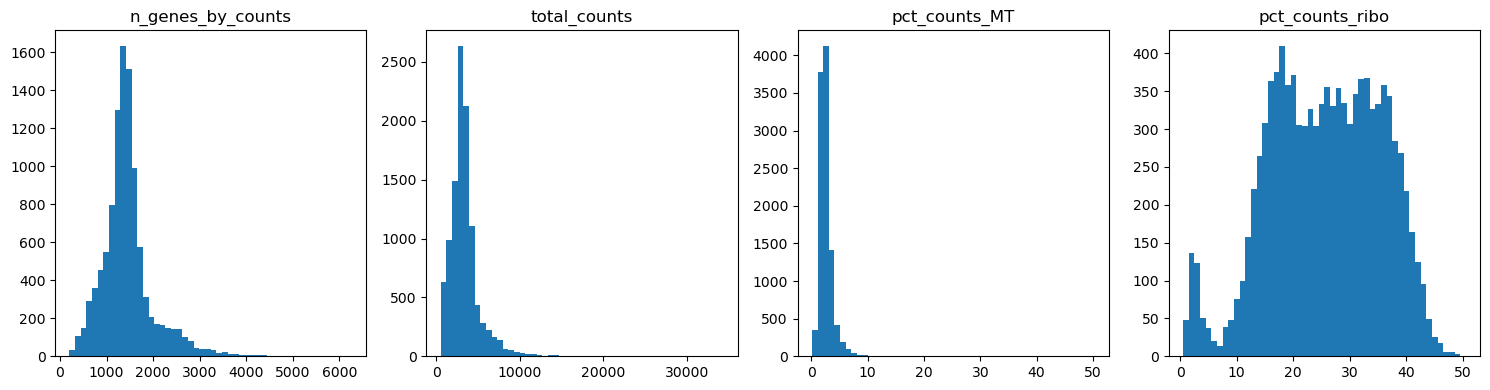

In [10]:
# Histogram of the cell quality

for adata in [normal_2, normal_3]:
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    n_bins = 50
    ax[0].hist(adata.obs.n_genes_by_counts, bins = n_bins)
    ax[0].set_title("n_genes_by_counts")
    ax[1].hist(adata.obs.total_counts, bins = n_bins)
    ax[1].set_title("total_counts")
    # ax[2].hist(adata.obs.pct_counts_Malat1, bins=50)
    # ax[2].set_title("pct_counts_MALAT1")
    ax[3].hist(adata.obs.pct_counts_ribo, bins = n_bins)
    ax[3].set_title("pct_counts_ribo")
    # ax[1].hist(adata.obs.pct_counts_hb, bins=50)
    # ax[1].set_title("pct_counts_hb")
    ax[2].hist(adata.obs.pct_counts_MT, bins = n_bins)
    ax[2].set_title("pct_counts_MT")

    plt.tight_layout()
    plt.show

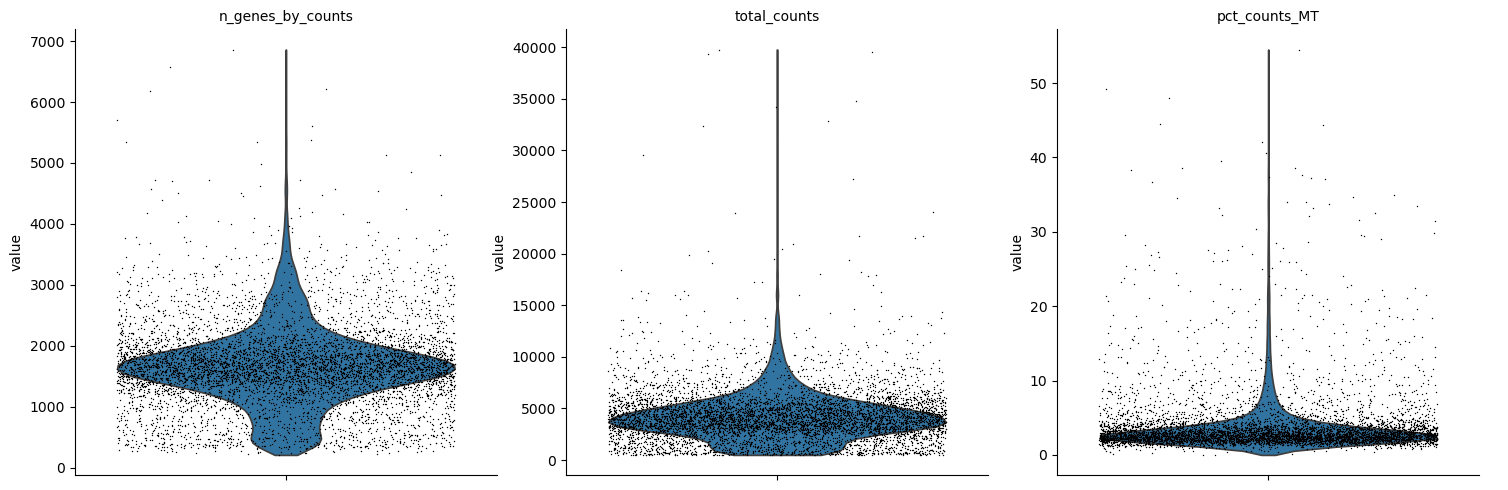

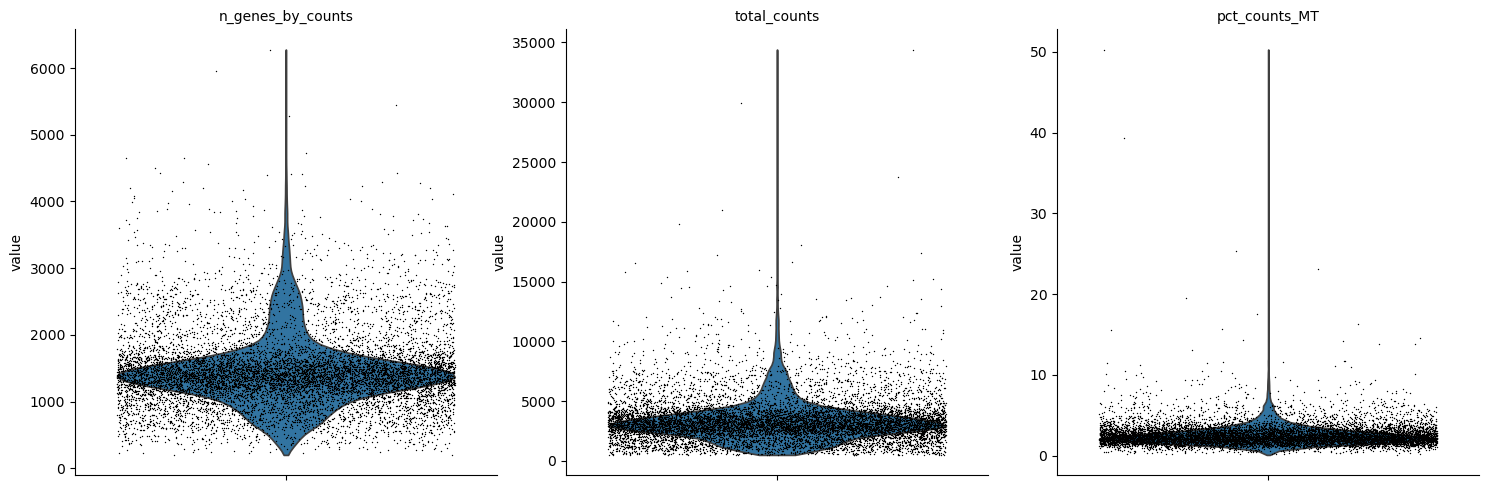

In [11]:
# violin plot of the cell quality

for adata in [normal_2, normal_3]:
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_MT"],
        jitter=0.4,
        multi_panel=True
    )

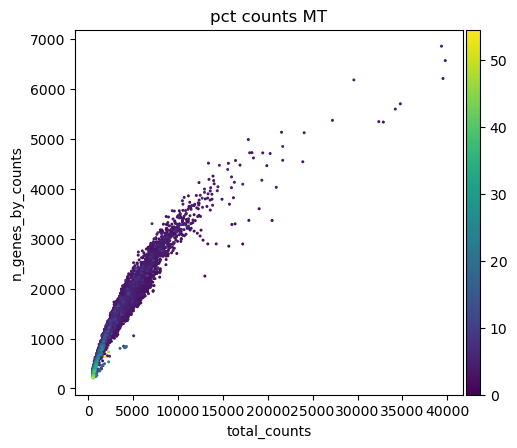

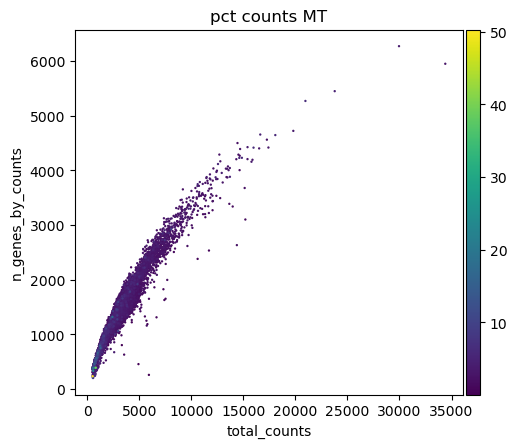

In [12]:
# scatterplot of the cell quality

rcParams['figure.figsize'] = 5, 5 # width, height

for adata in [normal_2, normal_3]:
    # plt.figure(figsize=(5, 5))
    sc.pl.scatter(
        adata,
        "total_counts",
        "n_genes_by_counts",
        color="pct_counts_MT"
    )
    # plt.show()
 

In [13]:
normal_2

AnnData object with n_obs × n_vars = 6447 × 25357
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_MALAT1', 'log1p_total_counts_MALAT1', 'pct_counts_MALAT1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'MT', 'ribo', 'MALAT1', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## MAD filtering

In [14]:
# Calculate MAD
# https://tomorrow-lab.github.io/posts/drylab/python_scRNA_QC.html

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * scipy.stats.median_abs_deviation(M)) | (
        np.median(M) + nmads * scipy.stats.median_abs_deviation(M) < M
    )
    return outlier


for adata in [normal_2, normal_3]:
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    print(adata.obs.outlier.value_counts(), "\n")
    
for adata in [normal_2, normal_3]:
    adata.obs["MT_outlier"] = is_outlier(adata, "pct_counts_MT", 3) |(
        adata.obs["pct_counts_MT"] > 8
    )
    print(adata.obs.MT_outlier.value_counts(), "\n")

outlier
False    5883
True      564
Name: count, dtype: int64 

outlier
False    9854
True      627
Name: count, dtype: int64 

MT_outlier
False    5493
True      954
Name: count, dtype: int64 

MT_outlier
False    9432
True     1049
Name: count, dtype: int64 



## Actual filtering using MAD

In [15]:
def MAD_filtering (adata):
    print(f"Cell number before filtering: {adata.n_obs}")
    adata = adata[(~adata.obs.outlier) & (~adata.obs.MT_outlier)]
    
    print(f"Cell number after filtering: {adata.n_obs}")
    print()
    return adata

normal_2 = MAD_filtering(normal_2)
normal_3 = MAD_filtering(normal_3)

Cell number before filtering: 6447
Cell number after filtering: 5385

Cell number before filtering: 10481
Cell number after filtering: 9022



In [21]:
type(normal_2.X.T)

scipy.sparse._csc.csc_matrix